In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/pd/chest_xray.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


**Importing libraries**

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2
from PIL import Image

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten, BatchNormalization 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

**Defining the directories**

In [ ]:
mainDIR = os.listdir('chest_xray')
print(mainDIR)

['train', 'test', 'val']


In [ ]:
train_folder= '/content/chest_xray/train/'
val_folder = '/content/chest_xray/val/'
test_folder = '/content/chest_xray/test/'

In [ ]:
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

### Data Visualization and Preprocessing

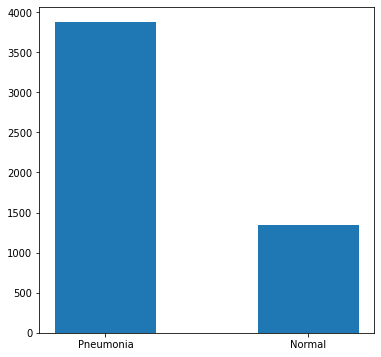

In [ ]:
data = {}
data["Pneumonia"] = len(os.listdir(train_p))
data["Normal"] = len(os.listdir(train_n))
  
fig = plt.figure(figsize = (6, 6))
 
# creating the bar plot
plt.bar(data.keys(), data.values(), width= 0.5)
plt.show()

**Data Augmentation**

In [ ]:
len(os.listdir(train_n))

1341

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        rotation_range = 20,  # randomly rotate images in the range (0 to 20) degrees
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True)  # randomly flip images


In [ ]:
os.chdir(train_n)
for path in os.listdir():
  img = load_img(f"{path}")
  x = img_to_array(img)    # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape)
  i = 0
  for batch in datagen.flow(x, batch_size=1, save_to_dir=".", save_prefix='img', save_format='jpeg'):
    i += 1
    if i > 2:      
      break

In [ ]:
len(os.listdir(train_n))

4647

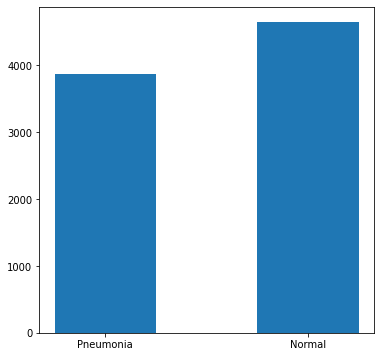

In [ ]:
data = {}
data["Pneumonia"] = len(os.listdir(train_p))
data["Normal"] = len(os.listdir(train_n))
  
fig = plt.figure(figsize = (6, 6))
 
# creating the bar plot
plt.bar(data.keys(), data.values(), width= 0.5)
plt.show()

**Showing sample x-ray images**

Text(0.5, 1.0, 'Pneumonia')

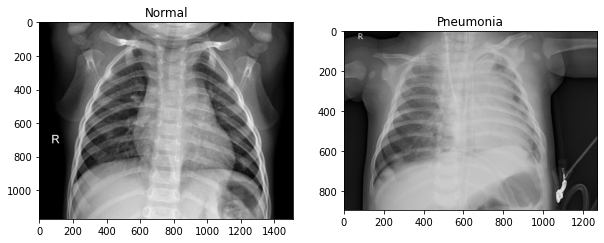

In [ ]:
#Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

# plt the images
f = plt.figure(figsize= (10,6))

a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia')

**Loading the images**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data(train_folder)
test = get_data(test_folder)
val = get_data(val_folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# grayscale normalization to the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

### Building the CNN model

In [ ]:
cnn = Sequential()

#Convolution
cnn.add(Conv2D(32, (3, 3), padding = 'same', activation="relu", input_shape=(150, 150, 1)))
cnn.add(BatchNormalization())
#Pooling
cnn.add(MaxPool2D(pool_size = (2, 2), padding = 'same'))

# 2nd Convolution
cnn.add(Conv2D(64, (3, 3), padding = 'same', activation="relu"))
cnn.add(BatchNormalization())
# 2nd Pooling layer
cnn.add(MaxPool2D(pool_size = (2, 2), padding = 'same'))

# 3rd Convolution
cnn.add(Conv2D(64, (3, 3), padding = 'same', activation="relu"))
cnn.add(BatchNormalization())
# 3rd Pooling layer
cnn.add(MaxPool2D(pool_size = (2, 2), padding = 'same'))

# 4th Convolution
cnn.add(Conv2D(128, (3, 3), padding = 'same', activation="relu"))
cnn.add(BatchNormalization())
# 4th Pooling layer
cnn.add(MaxPool2D(pool_size = (2, 2), padding = 'same'))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)       

### Training the Model

In [ ]:
history = cnn.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs = 10, 
                    validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
267/267 [==============================] - 17s 65ms/step - loss: 0.1121 - accuracy: 0.9580 - val_loss: 0.3847 - val_accuracy: 0.8125
Epoch 2/10
267/267 [==============================] - 17s 64ms/step - loss: 0.1120 - accuracy: 0.9588 - val_loss: 1.7335 - val_accuracy: 0.6250
Epoch 3/10
267/267 [==============================] - 17s 64ms/step - loss: 0.1038 - accuracy: 0.9605 - val_loss: 1.1361 - val_accuracy: 0.6250
Epoch 4/10
267/267 [==============================] - 17s 65ms/step - loss: 0.1069 - accuracy: 0.9614 - val_loss: 1.8334 - val_accuracy: 0.5625
Epoch 5/10
267/267 [==============================] - 18s 66ms/step - loss: 0.1083 - accuracy: 0.9625 - val_loss: 0.5462 - val_accuracy: 0.7500
Epoch 6/10
267/267 [==============================] - 18s 66ms/step - loss: 0.0955 - accuracy: 0.9662 - val_loss: 1.1916 - val_accuracy: 0.5625
Epoch 7/10
267/267 [==============================] - 18s 66ms/step - loss: 0.0947 - accuracy: 0.9663 - val_loss: 1.0474 - val_accuracy:

### Model Evaluation

In [ ]:
print("Loss of the model is - " , cnn.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , cnn.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 16ms/step - loss: 0.2826 - accuracy: 0.8750
Loss of the model is -  0.28264957666397095
20/20 [==============================] - 0s 15ms/step - loss: 0.2826 - accuracy: 0.8750
Accuracy of the model is -  87.5 %


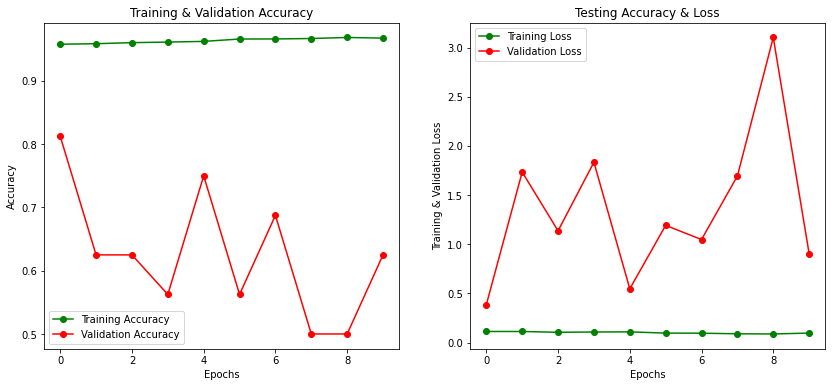

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14,6)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = cnn.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.87      0.90       390
   Normal (Class 1)       0.80      0.88      0.84       234

           accuracy                           0.88       624
          macro avg       0.86      0.88      0.87       624
       weighted avg       0.88      0.88      0.88       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[339,  51],
       [ 27, 207]])

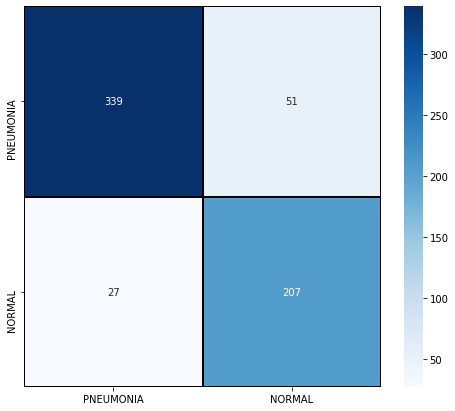

In [ ]:
import seaborn as sns
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (8,7))
sns.heatmap(cm ,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)